In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import filter_unwanted_seqs

2023-09-07 15:15:04.888776: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 15:15:04.926551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 15:15:04.927118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 15:15:05.977224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

In [2]:
def read_esm2(path_to_enzyme_esm2: str):
    """
    Reads in esm2 type embeddings and extracts headers and embeddings (as two separate lists)
    :param path_to_enzyme_esm2: Path to esm2
    :return: headers: list[str], embeddings: list[np.array]
    """

    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        headers = list(hdf_handle.keys())
        embeddings = [np.array(emb) for header, emb in hdf_handle.items()]

        return pd.DataFrame(data={"Entry":headers, "Embedding":embeddings})


def read_data(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv: str):
    """
    Reads in esm2 and splitX.csv
    :param path_to_enzyme_esm2: Absolute path to enzyme_esm2_splitX
    :param path_to_enzyme_splitX_csv: Absolute path to enzyme_splitX.csv
    :return: A dataframe (representing splitX.csv), headers of esm2 (list), esm2 embeddings (list)
    """
    embedding_df = read_esm2(path_to_enzyme_esm2=path_to_enzyme_esm2)
    print("LOG: ESM2 DONE")

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep='\t', index_col=0)
    print("LOG: CSV DONE")


    # control
    print(embedding_df.head())
    print("Enzymes in SplitX.csv:", len(enzyme_csv))
    return [embedding_df, enzyme_csv]


### Creating X and y
#### Reading in data (splitX.csv and esm2_splitX)

In [3]:
enzyme_csv_path = os.getenv("METADATA_CSV")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_10")
emb_df, enz_df = read_data(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)

LOG: ESM2 DONE
LOG: CSV DONE
        Entry                                          Embedding
0  A0A024RBG1  [-0.015143169, 0.035552002, -0.02231326, 0.002...
1  A0A024SMV2  [0.059097216, -0.034141198, 0.061426997, 0.006...
2  A0A096ZEC9  [-0.010234033, -0.029855184, 0.017577162, -0.0...
3  A0A0A1H8I4  [-0.01968652, 0.003559523, -0.039232656, -0.02...
4  A0A0B0QJN8  [-0.021025013, -0.010405256, -0.02915452, 0.01...
Enzymes in SplitX.csv: 224693


#### Now we initialize X and y 

In [15]:
X = []
y = []

for label in emb_df["Entry"]:
    number = enz_df.loc[enz_df["Entry"] == label,"EC number"]
    ec = int(number.iat[0][0])-1 # since we always start counting from 0
    y.append(ec) # append label (1-7)
    X.append(emb_df.loc[emb_df["Entry"] == label, "Embedding"].values[0]) # append embedding
    
X = np.array(X)

### Control

In [16]:

print(len(y))
print(len(X))


7212
7212


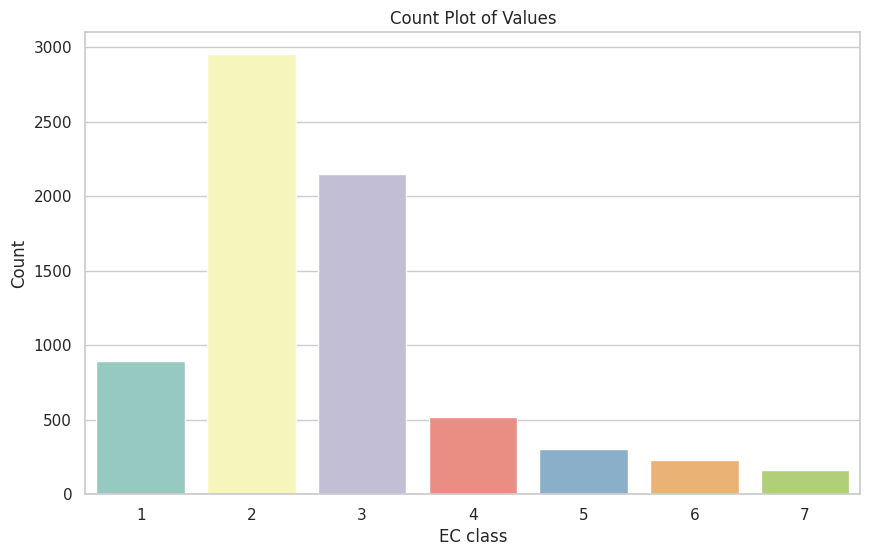

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()

### Splitting data into train and test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7) 
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)
print(y_test_encoded[0])

[0. 0. 1. 0. 0. 0. 0.]


## Creating our CNN

In [19]:
# This is used for stopping the training precess in advance, if our model starts to overfit our training data
earl_stop = tf.keras.callbacks.EarlyStopping(patience=5)

In [20]:
# Initializing the model
model = tf.keras.models.Sequential()

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [21]:
# Training the model
model.fit(x=X_train, y=y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/100
158/158 [==============================] - 3s 12ms/step - loss: 1.4746 - val_loss: 1.2795
Epoch 2/100
158/158 [==============================] - 2s 11ms/step - loss: 1.1880 - val_loss: 0.9869
Epoch 3/100
158/158 [==============================] - 2s 11ms/step - loss: 0.9685 - val_loss: 0.8264
Epoch 4/100
158/158 [==============================] - 2s 11ms/step - loss: 0.8328 - val_loss: 0.7936
Epoch 5/100
158/158 [==============================] - 2s 11ms/step - loss: 0.7655 - val_loss: 0.6923
Epoch 6/100
158/158 [==============================] - 2s 12ms/step - loss: 0.6727 - val_loss: 0.6564
Epoch 7/100
158/158 [==============================] - 2s 12ms/step - loss: 0.6419 - val_loss: 0.6437
Epoch 8/100
158/158 [==============================] - 2s 11ms/step - loss: 0.5580 - val_loss: 0.6589
Epoch 9/100
158/158 [==============================] - 2s 11ms/step - loss: 0.5434 - val_loss: 0.6427
Epoch 10/100
158/158 [==============================] - 2s 11ms/step - loss: 0.507

# Evaluation

<Figure size 1000x600 with 0 Axes>

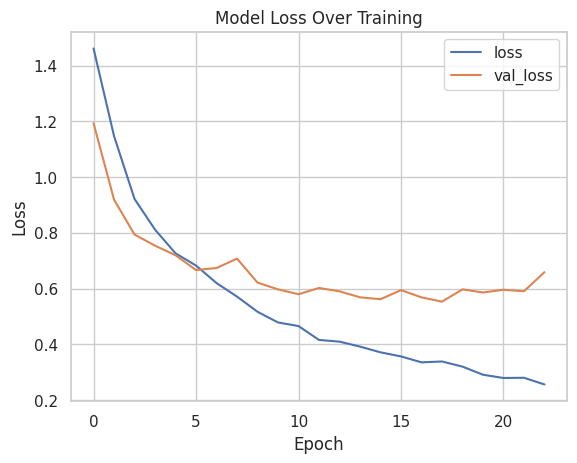

In [81]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

68/68 [==============================] - 0s 2ms/step


In [23]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  1803
Total samples predicted: 2164


In [24]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       263
           1       0.87      0.90      0.89       878
           2       0.89      0.89      0.89       655
           3       0.47      0.63      0.54       154
           4       0.68      0.38      0.48        96
           5       0.90      0.75      0.82        72
           6       0.86      0.78      0.82        46

    accuracy                           0.83      2164
   macro avg       0.79      0.73      0.75      2164
weighted avg       0.84      0.83      0.83      2164


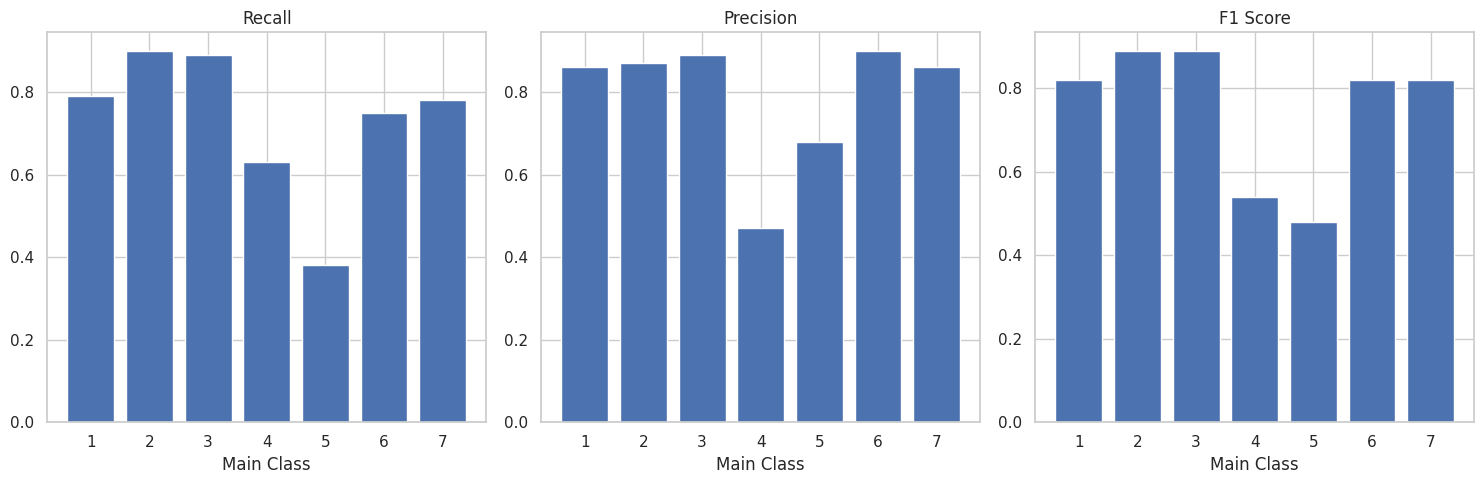

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       263
           1       0.87      0.90      0.89       878
           2       0.89      0.89      0.89       655
           3       0.47      0.63      0.54       154
           4       0.68      0.38      0.48        96
           5       0.90      0.75      0.82        72
           6       0.86      0.78      0.82        46

    accuracy                           0.83      2164
   macro avg       0.79      0.73      0.75      2164
weighted avg       0.84      0.83      0.83      2164


In [25]:
class_0_metrics = report.split('\n')[2].split()[1:]
class_1_metrics = report.split('\n')[3].split()[1:]
class_2_metrics = report.split('\n')[4].split()[1:]
class_3_metrics = report.split('\n')[5].split()[1:]
class_4_metrics = report.split('\n')[6].split()[1:]
class_5_metrics = report.split('\n')[7].split()[1:]
class_6_metrics = report.split('\n')[8].split()[1:]

metrics = [class_0_metrics,
           class_1_metrics,
           class_2_metrics,
           class_3_metrics,
           class_4_metrics,
           class_5_metrics,
           class_6_metrics
           ]
i = 1
precs = []
recs = []
f1_s = []
for class_m in metrics:
    precision = float(class_m[0])
    recall = float(class_m[1])
    f1_score = float(class_m[2])
    precs.append(precision)
    recs.append(recall)
    f1_s.append(f1_score)
    i+=1

class_names = [1,2,3,4,5,6,7]

# Create subplots for accuracy, precision, and F1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot accuracy for each class
ax1.bar(class_names, recs)
ax1.set_title("Recall")
ax1.set_xlabel("Main Class")


# Plot precision for each class
ax2.bar(class_names, precs)
ax2.set_title("Precision")
ax2.set_xlabel("Main Class")

# Plot F1 score for each class
ax3.bar(class_names, f1_s)
ax3.set_title("F1 Score")
ax3.set_xlabel("Main Class")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

print(report)

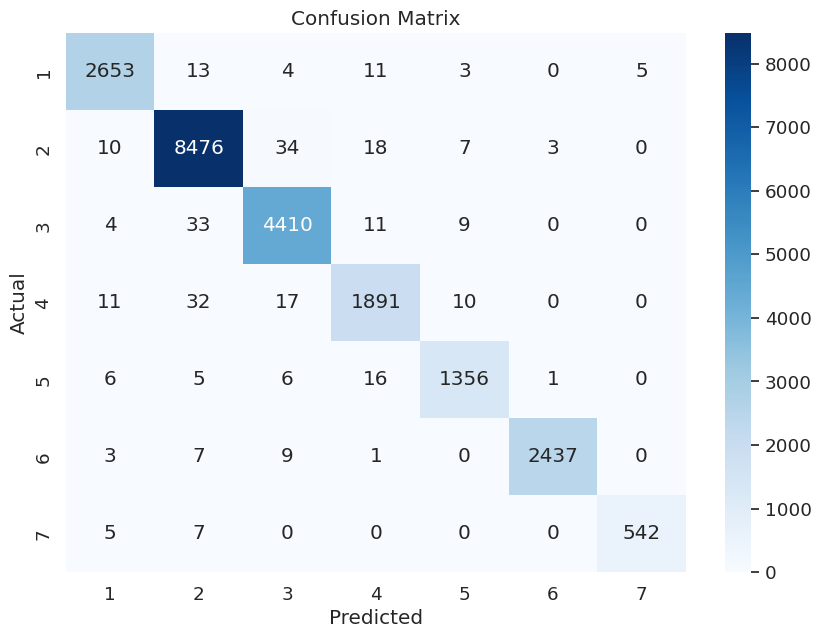

In [23]:
conf_matrix = confusion_matrix(y_test, predictions)
# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)  # Adjust font size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
model.save("initial_cnn_v3_acc99.keras")

# Importing and using my model
## 1. Load model

In [ ]:
loaded_model = tf.keras.models.load_model("initial_cnn_v3_acc99.keras")

## 2. Predict new data
The data needs to be the same shape as the training/test data used to train the model.
The unlabeled embeddings need to be imported into a dataframe and then we need to create a feature column for each 
value of the embedding.


In [ ]:

test_enzyme_csv_path = os.getenv("CSV70_ENZYMES_test")
test_esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_70_test")

data = read_data(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
enzyme_csv = data[0]
entry_ids = data[1]
embeddings = data[2]

test_embedding_labels = add_labels(enzyme_csv, entry_ids, embeddings)

# embedding_labels = get_ec_labels(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
X_test= []
y_test = []

for label in embedding_labels:
    y_test.append(label[1]) # append label (1-7)
    X_test.append(label[2]) # append embedding

print(len(X_test))
print(len(y_test))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()
loaded_model.predict()

X_test = df.drop('label', axis=1).values
y_test = df['label'].values

test_predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)


report = classification_report(y_test, test_predictions)
